<a href="https://colab.research.google.com/github/tozanni/nma_wcst_rl/blob/main/human_rl_wcst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using RL to Model Wisconsin Card Sorting Task


**Original notebook credits:**

__Content creators:__ Morteza Ansarinia, Yamil Vidal

__Production editor:__ Spiros Chavlis


---
# Objective

- This project aims to use behavioral data to train an agent and then use the agent to investigate data produced by human subjects. Having a computational agent that mimics humans in such tests, we will be able to compare its mechanics with human data.

- In another conception, we could fit an agent that learns many cognitive tasks that require abstract-level constructs such as executive functions. This is a multi-task control problem.




---
# Setup

In [1]:
# @title Install dependencies
!pip install jedi --quiet
!pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet
!pip install numpy==1.23.3 --quiet --ignore-installed
!pip uninstall seaborn -y --quiet
!pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 130.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00
    

In [2]:
# Imports
import time
import numpy as np
import pandas as pd
import sonnet as snt
import seaborn as sns
import matplotlib.pyplot as plt

import dm_env

import acme
from acme import specs
from acme import wrappers
from acme import EnvironmentLoop
from acme.agents.tf import dqn
from acme.utils import loggers

RuntimeError: ignored

RuntimeError: ignored

/usr/local/lib/python3.10/dist-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(version) <
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---
# Background

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

## Datasets

This notebook works on simulated data only.

## N-back task

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

---
# Cognitive Tests Environment

First we develop an environment in that agents perform a cognitive test, here the N-back.

## Implementation scheme


### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [4]:
class NBack(dm_env.Environment):

  ACTIONS = ['match', 'non-match']

  def __init__(self,
               N=2,
               episode_steps=32,
               stimuli_choices=list('ABCDEF'),
               human_data=None,
               seed=1,
               ):
    """
    Args:
      N: Number of steps to look back for the matched stimuli. Defaults to 2 (as in 2-back).
      episode_steps
      stimuli_choices
      human_data
      seed

    """
    self.N = N
    self.episode_steps = episode_steps
    self.stimuli_choices = stimuli_choices
    self.stimuli = np.empty(shape=episode_steps)  # will be filled in the `reset()`

    self._reset_next_step = True

    # whether mimic humans or reward the agent once it responds optimally.
    if human_data is None:
      self._imitate_human = False
      self.human_data = None
      self.human_subject_data = None

    self._action_history = []

  def reset(self):
    self._reset_next_step = False
    self._current_step = 0
    self._action_history.clear()

    # generate a random sequence instead of relying on human data
    if self.human_data is None:
      # self.stimuli = np.random.choice(self.stimuli_choices, self.episode_steps)
      # FIXME This is a fix for acme & reverb issue with string observation. Agent should be able to handle strings
      self.stimuli = np.random.choice(len(self.stimuli_choices), self.episode_steps).astype(np.float32)

    return dm_env.restart(self._observation())


  def _episode_return(self):
    if self._imitate_human:
      return np.mean(self.human_subject_data['response'] == self._action_history)
    else:
      return 0.0

  def step(self, action: int):
    if self._reset_next_step:
      return self.reset()

    agent_action = NBack.ACTIONS[action]

    # assume the agent is rationale and doesn't want to reproduce human, reward once the response it correct
    expected_action = 'match' if (self.stimuli[self._current_step] == self.stimuli[self._current_step - self.N]) else 'non-match'
    step_reward = 0. if (agent_action == expected_action) else -1.
    self._action_history.append(agent_action)
    self._current_step += 1

    # Check for termination.
    if self._current_step == self.stimuli.shape[0]:
      self._reset_next_step = True
      # we are using the mean of total time step rewards as the episode return
      return dm_env.termination(reward=self._episode_return(),
                                observation=self._observation())
    else:
      return dm_env.transition(reward=step_reward,
                               observation=self._observation())

  def observation_spec(self):
    return dm_env.specs.BoundedArray(
        shape=self.stimuli.shape,
        dtype=self.stimuli.dtype,
        name='nback_stimuli', minimum=0, maximum=len(self.stimuli_choices) + 1)

  def action_spec(self):
    return dm_env.specs.DiscreteArray(
        num_values=len(NBack.ACTIONS),
        dtype=np.int32,
        name='action')

  def _observation(self):

    # agent observes only the current trial
    # obs = self.stimuli[self._current_step - 1]

    # agents observe stimuli up to the current trial
    obs = self.stimuli[:self._current_step+1].copy()
    obs = np.pad(obs,(0, len(self.stimuli) - len(obs)))

    return obs

  def plot_state(self):
    """Display current state of the environment.

     Note: `M` mean `match`, and `.` is a `non-match`.
    """
    stimuli = self.stimuli[:self._current_step - 1]
    actions = ['M' if a=='match' else '.' for a in self._action_history[:self._current_step - 1]]
    return HTML(
        f'<b>Environment ({self.N}-back):</b><br />'
        f'<pre><b>Stimuli:</b> {"".join(map(str,map(int,stimuli)))}</pre>'
        f'<pre><b>Actions:</b> {"".join(actions)}</pre>'
    )

  @staticmethod
  def create_environment():
    """Utility function to create a N-back environment and its spec."""

    # Make sure the environment outputs single-precision floats.
    environment = wrappers.SinglePrecisionWrapper(NBack())

    # Grab the spec of the environment.
    environment_spec = specs.make_environment_spec(environment)

    return environment, environment_spec

### Define a random agent

For more information you can refer to NMA-DL W3D2 Basic Reinforcement learning.

In [5]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

### Initialize the environment and the agent

In [6]:
env, env_spec = NBack.create_environment()
agent = RandomAgent(env_spec)

print('actions:\n', env_spec.actions)
print('observations:\n', env_spec.observations)
print('rewards:\n', env_spec.rewards)

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=1, num_values=2)
observations:
 BoundedArray(shape=(32,), dtype=dtype('float32'), name='nback_stimuli', minimum=0.0, maximum=7.0)
rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


### Run the loop

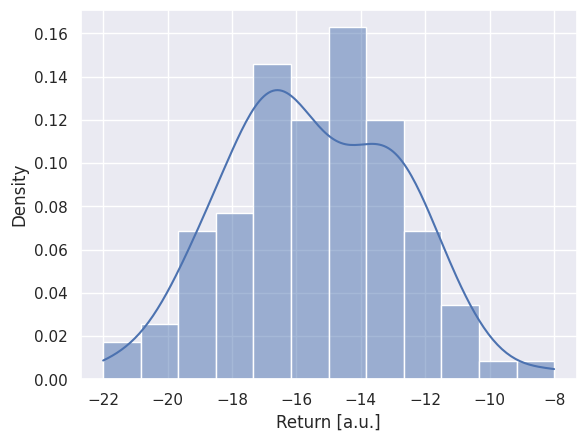

In [7]:
# fitting parameters
n_episodes = 100
n_total_steps = 0
log_loss = False
n_steps = n_episodes * 32
all_returns = []

# main loop
for episode in range(n_episodes):
  episode_steps = 0
  episode_return = 0
  episode_loss = 0

  start_time = time.time()

  timestep = env.reset()

  # Make the first observation.
  agent.observe_first(timestep)

  # Run an episode
  while not timestep.last():

    # DEBUG
    # print(timestep)

    # Generate an action from the agent's policy and step the environment.
    action = agent.select_action(timestep.observation)
    timestep = env.step(action)

    # Have the agent observe the timestep and let the agent update itself.
    agent.observe(action, next_timestep=timestep)
    agent.update()

    # Book-keeping.
    episode_steps += 1
    n_total_steps += 1
    episode_return += timestep.reward

    if log_loss:
      episode_loss += agent.last_loss

    if n_steps is not None and n_total_steps >= n_steps:
      break

  # Collect the results and combine with counts.
  steps_per_second = episode_steps / (time.time() - start_time)
  result = {
      'episode': episode,
      'episode_length': episode_steps,
      'episode_return': episode_return,
  }
  if log_loss:
    result['loss_avg'] = episode_loss/episode_steps

  all_returns.append(episode_return)

  display(env.plot_state())
  # Log the given results.
  print(result)

  if n_steps is not None and n_total_steps >= n_steps:
    break

clear_output()

# Histogram of all returns
plt.figure()
sns.histplot(all_returns, stat="density", kde=True, bins=12)
plt.xlabel('Return [a.u.]')
plt.ylabel('Density')
plt.show()

**Note:** You can simplify the environment loop using [DeepMind Acme](https://github.com/deepmind/acme).

In [8]:
# init a new N-back environment
env, env_spec = NBack.create_environment()

# DEBUG fake testing environment.
# Uncomment this to debug your agent without using the N-back environment.
# env = fakes.DiscreteEnvironment(
#     num_actions=2,
#     num_observations=1000,
#     obs_dtype=np.float32,
#     episode_length=32)
# env_spec = specs.make_environment_spec(env)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
def dqn_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.Sequential([
      snt.Flatten(),
      snt.nets.MLP([50, 50, action_spec.num_values]),
  ])

# construct a DQN agent
agent = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.5],
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

Now, we run the environment loop with the DQN agent and print the training log.

In [10]:
# training loop
loop = EnvironmentLoop(env, agent, logger=loggers.InMemoryLogger())
loop.run(n_episodes)

# print logs
logs = pd.DataFrame(loop._logger._data)
logs.tail()

,episode_length,episode_return,steps_per_second,episodes,steps
95,32,-14.0,300.908948,96,3072
96,32,-14.0,358.712675,97,3104
97,32,-14.0,200.145135,98,3136
98,32,-13.0,306.972824,99,3168
99,32,-13.0,334.002897,100,3200
